<a href="https://colab.research.google.com/github/vilmosbilicki/cartpole_game/blob/main/LEGO_MI_3_alkalom_RL_DQN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Környezet inicializálása

In [ ]:
import gymnasium as gym

In [ ]:
env = gym.make("CartPole-v1", render_mode = "rgb_array")

In [ ]:
states = env.observation_space.shape[0]
actions = env.action_space.n

print(states, "állapot paraméter: hely, sebesség, dőlési szög, szögsebesség")
print(actions, "action: jobbra, balra")

4 állapot paraméter: hely, sebesség, dőlési szög, szögsebesség
2 action: jobbra, balra


A videók Google Colab-ban való megjelenítése egy kis workaround-ot igényel, főleg ha azokban a gymnasium környezet szeretnénk reprezentálni. Szerencsénkre ez a probléma másokat is zavart, így készült rá több megoldás, mi most az alábbit használjuk:

https://github.com/ryanrudes/renderlab

In [ ]:
!pip install renderlab

In [ ]:
import renderlab

  if event.key is 'enter':



In [ ]:
env = renderlab.RenderFrame(env, "./output") # renderlab inicializálás, videók output mappájának megadása

Innentől kezdve az *env.play()* föggvény elkészíti nekünk a videót a jelenlegi környezet (env változóban tárolódik) alapján.



# Mit történik, ha random action-öket választunk?

In [ ]:
random_scores = []
episodes = 10

# Minden epizód egy kísérlet a CartPole játékban
for episode in range(1, episodes+1):
  # Minden epizódnál az elején visszaállítjuk a CartPole-t kezdeti állapotba
  state, info = env.reset()
  # Az epizód összesített jutalma (értelemszerűen 0-ról indulunk)
  score = 0

  # Az adott epizód végrehajtása
  while True:
    # Veszünkegy random action-t a lehetségesek közül
    action = env.action_space.sample()

    # Végrehajtjuk az action-t
    # reward: +1 minden olyan időegységért, amikor nem dőlt el a bot
    # terminated: igaz, ha a bot eldőlt vagy a kocsi kiment a játéktérből
    # truncated: igaz, ha az epizód elérte a maximális hosszát (500 frame)
    state, reward, terminated, truncated, info = env.step(action)

    # Növeljük a pontszámot
    score += reward

    # Ellenőrizzük, hogy véget ért-e az epiződ. Ha igen, kiírjuk az aktuális pontszámot, majd kilépünk a ciklusból.
    if terminated or truncated:
      print('Episode:{} Score:{}'.format(episode, score))
      random_scores.append(score)
      break

  env.play()

Episode:1 Score:44.0
Moviepy - Building video temp-{start}.mp4.
Moviepy - Writing video temp-{start}.mp4



Moviepy - Done !
Moviepy - video ready temp-{start}.mp4


Episode:2 Score:23.0
Moviepy - Building video temp-{start}.mp4.
Moviepy - Writing video temp-{start}.mp4



Moviepy - Done !
Moviepy - video ready temp-{start}.mp4


Episode:3 Score:17.0
Moviepy - Building video temp-{start}.mp4.
Moviepy - Writing video temp-{start}.mp4



Moviepy - Done !
Moviepy - video ready temp-{start}.mp4


Episode:4 Score:15.0
Moviepy - Building video temp-{start}.mp4.
Moviepy - Writing video temp-{start}.mp4



Moviepy - Done !
Moviepy - video ready temp-{start}.mp4


Episode:5 Score:27.0
Moviepy - Building video temp-{start}.mp4.
Moviepy - Writing video temp-{start}.mp4



Moviepy - Done !
Moviepy - video ready temp-{start}.mp4


Episode:6 Score:11.0
Moviepy - Building video temp-{start}.mp4.
Moviepy - Writing video temp-{start}.mp4



Moviepy - Done !
Moviepy - video ready temp-{start}.mp4


Episode:7 Score:15.0
Moviepy - Building video temp-{start}.mp4.
Moviepy - Writing video temp-{start}.mp4



Moviepy - Done !
Moviepy - video ready temp-{start}.mp4


Episode:8 Score:12.0
Moviepy - Building video temp-{start}.mp4.
Moviepy - Writing video temp-{start}.mp4



Moviepy - Done !
Moviepy - video ready temp-{start}.mp4


Episode:9 Score:39.0
Moviepy - Building video temp-{start}.mp4.
Moviepy - Writing video temp-{start}.mp4



Moviepy - Done !
Moviepy - video ready temp-{start}.mp4


Episode:10 Score:12.0
Moviepy - Building video temp-{start}.mp4.
Moviepy - Writing video temp-{start}.mp4



Moviepy - Done !
Moviepy - video ready temp-{start}.mp4


In [ ]:
print("Minimum score: ", min(random_scores))
print("Maximum score: ", max(random_scores))
print("Average score: ", sum(random_scores)/len(random_scores))

Minimum score:  11.0
Maximum score:  44.0
Average score:  21.5


# Ágens létrehozása

Szükséges könyvtárak importálása

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
import random
from collections import deque

DQN ágens definiálása

In [ ]:
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        # Experience Replay Buffer
        self.memory = deque(maxlen=100000)

        # discount rate a Q(s,a) formulában
        self.gamma = 0.99

        # az epsilon-greedy epsilonja magasan indít, és fokozatosan csökken
        self.epsilon = 0.9 # kezdeti értéke 1-hez közeli => eleinte a legtöbb action random választott
        self.epsilon_min = 0.01 # Minimum epsilon: 0.01: azt biztosítja, hogy a végső epizódoknál is legyen felfedezés
        self.epsilon_decay = 0.99 # Epsilon csökkenés: 0.99: ezzel szorozzuk epsilont, azaz ilyen mértékben csökkentjük
        self.learning_rate = 0.001
        self.model = self._build_model()



    """
    Első fügvény: modell felépítése:
    - lineáris feed-forward neurális háló
    - bemeneti réteg:
        - 4 elemű vektor az állapotokról: pozíció, sebesség, szög, szögsebesség
        - Flatten: réteg ami az adatok kötegelt kezelésére alkalmas
    - két rejtett réteg:
        - 128-64 neuronnal
        - RELU aktivációs függvény: max(0, x): célja: "minél pozitívabb, annál inkább aktivált egy csúcs"
    - kimeneti rétegek:
        - annyi kimeneti neuron, ahány lehetséges actionünk van (jelenleg 2: a kocsi balra vagy jobbra menjen)
        - q-értékek: minden output a jövőbeli jutalom mértékét reprezentálja egy-egy actiön-re
    - loss function: MSE - átlagos négyzetes eltérés (hiba)
    - Adam: optimalizáló
    """
    def _build_model(self):
        model = Sequential()
        model.add(Flatten(input_shape=(1, self.state_size)))
        model.add(Dense(128, activation='relu'))
        model.add(Dense(64, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss='mse', optimizer=Adam(learning_rate=self.learning_rate))
        return model


    """
    Második függvény: tapasztalatok eltárolása:
    minden, a környezettel történő interakció után meghívódik, generál egy új tapasztalatot,
    azaz egy új rekordot az Experience Replay Bufferbe
    """
    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))


    """
    Harmadik függvény: epsilon-greedy implementálása:
    """
    def act(self, state):
        # ha a random generált szám (0 és 1 közötti) kisebb mint epszilon, akkor random action-t választunk
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        # egyébként neurális hálóval meghatározzuk a maximális Q-értékű action-t és azt választjuk
        act_values = self.model.predict(state, verbose=0)
        return np.argmax(act_values[0])


    """
    Negyedik függvény: a modell tanulása:
    """
    def replay(self, batch_size):
        # ha még nincs elég tapasztalat a bufferben a random mintavételezésre (32)
        if len(self.memory) < batch_size:
            return

        # mintavételezünk a tapasztalatokból
        minibatch = random.sample(self.memory, batch_size)

        # végigmegyünk a minibatch rekordjain
        for state, action, reward, next_state, done in minibatch:
            # azonnali jutalom
            target = reward
            # ha nem ér véget a szekvencia ezzel az action-nel
            if not done:
                # Bellman egyenlet a kódban implementálva:
                target = (reward + self.gamma * np.amax(self.model.predict(next_state, verbose=0)[0]))
            # frissítjük a kiválasztott action Q-értékét
            target_f = self.model.predict(state, verbose=0)
            target_f[0][action] = target
            # modell súlyainak finomítása, hogy csökkentse a hibát a jósolt Q érték és a cél között
            self.model.fit(state, target_f, epochs=1, verbose=0)

        # szabály az epsilon fokozatos csökkentésére, hogy az idő múltával csökkenjen a kísérletezés
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

# Ügynök inicializálása
agent = DQNAgent(states, actions)

  super().__init__(**kwargs)



# Ágens tanítása

In [ ]:
# Tanítási paraméterek
EPISODES = 400
batch_size = 64
output_freq = 40  # Milyen gyakran mutassuk meg az outputot

# Eredmények eltárolására használt listák
scores = []
epsilon_values = []

# Az alábbi rész fog felelni a training folyamatért és a kiértékelésért

# Training loop, adott számú epizódig fut
for episode in range(1, EPISODES+1):
    state, info = env.reset() # CartPole vissza az eredeti állapotba
    score = 0

    # Átalakítjuk az állapotvektort a neurális háló által elvárt formátumba
    state = np.reshape(state, [1, 1, states])

    # Az adott epizód végrehajtása
    while True:
        # Epsilon-greedy stratégia alapján végrehajt egy action-t
        action = agent.act(state)
        # reward: +1 minden olyan időegységért, amikor nem dőlt el a bot
        # terminated: igaz, ha a bot eldőlt vagy a kocsi kiment a játéktérből
        # truncated: igaz, ha az epizód elérte a maximális hosszát (500 frame)
        next_state, reward, terminated, truncated, info = env.step(action)
        next_state = np.reshape(next_state, [1, 1, states])

        # Bufferbe belerakjuk a tapasztalatot
        agent.remember(state, action, reward, next_state, terminated or truncated)

        # Frissítjük az állapotot, növeljük a pontszámot
        state = next_state
        score += reward

        if terminated or truncated:
            break

    # Minden teljesített epizód után ellenőrizzük, hogy elég tapasztalat gyűlt-e össze, és ha igen,
    # akkor tanítjuk a neurális hálót a véletlenszerű mintavétellel
    if len(agent.memory) > batch_size:
        agent.replay(batch_size)

    # Pontszám és epsilon listába vétele
    scores.append(score)
    epsilon_values.append(agent.epsilon)

    # Videók kijelzése
    if episode % output_freq == 0:
        env.play()
        print(f"Episode: {episode}/{EPISODES}, Score: {score}, Epsilon: {agent.epsilon:.2f}")

Moviepy - Building video temp-{start}.mp4.
Moviepy - Writing video temp-{start}.mp4



t:   0%|          | 0/12 [00:00<?, ?it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file ./output/1741715465.837039.mp4, 720000 bytes wanted but 0 bytes read,at frame 11/12, at time 0.37/0.37 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+

                                                   

Moviepy - Done !
Moviepy - video ready temp-{start}.mp4


Episode: 40/400, Score: 10.0, Epsilon: 0.62
Moviepy - Building video temp-{start}.mp4.
Moviepy - Writing video temp-{start}.mp4



Moviepy - Done !
Moviepy - video ready temp-{start}.mp4


Episode: 80/400, Score: 12.0, Epsilon: 0.42
Moviepy - Building video temp-{start}.mp4.
Moviepy - Writing video temp-{start}.mp4



Moviepy - Done !
Moviepy - video ready temp-{start}.mp4


Episode: 120/400, Score: 32.0, Epsilon: 0.28
Moviepy - Building video temp-{start}.mp4.
Moviepy - Writing video temp-{start}.mp4



Moviepy - Done !
Moviepy - video ready temp-{start}.mp4


Episode: 160/400, Score: 29.0, Epsilon: 0.19
Moviepy - Building video temp-{start}.mp4.
Moviepy - Writing video temp-{start}.mp4



Moviepy - Done !
Moviepy - video ready temp-{start}.mp4


Episode: 200/400, Score: 92.0, Epsilon: 0.12
Moviepy - Building video temp-{start}.mp4.
Moviepy - Writing video temp-{start}.mp4



Moviepy - Done !
Moviepy - video ready temp-{start}.mp4


Episode: 240/400, Score: 83.0, Epsilon: 0.08
Moviepy - Building video temp-{start}.mp4.
Moviepy - Writing video temp-{start}.mp4



Moviepy - Done !
Moviepy - video ready temp-{start}.mp4


Episode: 280/400, Score: 12.0, Epsilon: 0.06
Moviepy - Building video temp-{start}.mp4.
Moviepy - Writing video temp-{start}.mp4



Moviepy - Done !
Moviepy - video ready temp-{start}.mp4


Episode: 320/400, Score: 323.0, Epsilon: 0.04
Moviepy - Building video temp-{start}.mp4.
Moviepy - Writing video temp-{start}.mp4



t:  72%|███████▏  | 76/105 [00:00<00:00, 285.58it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file ./output/1741724562.290553.mp4, 720000 bytes wanted but 0 bytes read,at frame 104/105, at time 3.47/3.47 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



Moviepy - Done !
Moviepy - video ready temp-{start}.mp4


Episode: 360/400, Score: 103.0, Epsilon: 0.02
Moviepy - Building video temp-{start}.mp4.
Moviepy - Writing video temp-{start}.mp4



t:  99%|█████████▉| 98/99 [00:00<00:00, 227.99it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file ./output/1741726020.035621.mp4, 720000 bytes wanted but 0 bytes read,at frame 98/99, at time 3.27/3.27 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+

                                                             

Moviepy - Done !
Moviepy - video ready temp-{start}.mp4


Episode: 400/400, Score: 97.0, Epsilon: 0.02


### Ágens tanulásának vizualizációja

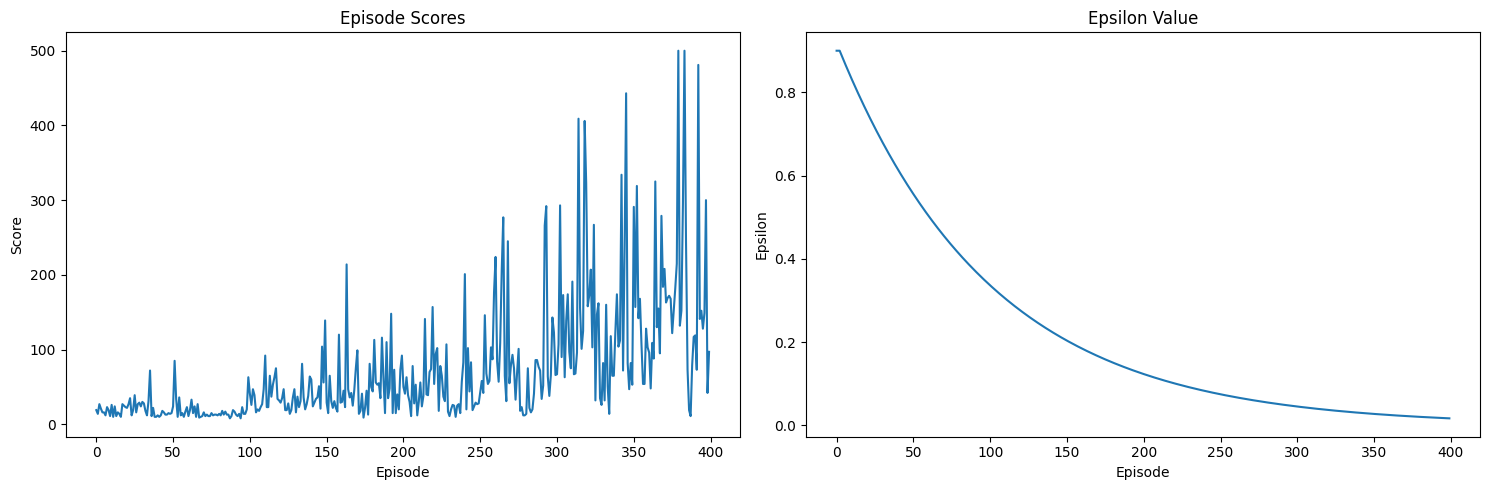

In [ ]:
import matplotlib.pyplot as plt

# Vizualizáció
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(scores)
plt.title('Episode Scores')
plt.xlabel('Episode')
plt.ylabel('Score')

plt.subplot(1, 2, 2)
plt.plot(epsilon_values)
plt.title('Epsilon Value')
plt.xlabel('Episode')
plt.ylabel('Epsilon')

plt.tight_layout()
plt.show()

# Betanult ágens tesztelése

In [ ]:
# Tesztelési rész
test_episodes = 10
test_scores = []

for e in range(1, test_episodes+1):
    state, info = env.reset()
    state = np.reshape(state, [1, 1, states])
    score = 0
    done = False

    while not done:
        # Mindig a legnagyobb Q-értéket választjuk (csak kihasználás, semmi felfedezés!)
        act_values = agent.model.predict(state, verbose=0)
        action = np.argmax(act_values[0])
        next_state, reward, terminated, truncated, info = env.step(action)
        next_state = np.reshape(next_state, [1, 1, states])

        state = next_state
        score += reward
        done = terminated or truncated

    env.play()  # Teszt epizód kiíratása
    test_scores.append(score)
    print(f"Test Episode: {e}/{test_episodes}, Score: {score}")

print(f"Average Test Score: {np.mean(test_scores)}")

Moviepy - Building video temp-{start}.mp4.
Moviepy - Writing video temp-{start}.mp4



t:  92%|█████████▏| 154/168 [00:00<00:00, 194.67it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file ./output/1741726119.515324.mp4, 720000 bytes wanted but 0 bytes read,at frame 167/168, at time 5.57/5.57 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



Moviepy - Done !
Moviepy - video ready temp-{start}.mp4


Test Episode: 1/10, Score: 166.0
Moviepy - Building video temp-{start}.mp4.
Moviepy - Writing video temp-{start}.mp4



Moviepy - Done !
Moviepy - video ready temp-{start}.mp4


Test Episode: 2/10, Score: 123.0
Moviepy - Building video temp-{start}.mp4.
Moviepy - Writing video temp-{start}.mp4



Moviepy - Done !
Moviepy - video ready temp-{start}.mp4


Test Episode: 3/10, Score: 159.0
Moviepy - Building video temp-{start}.mp4.
Moviepy - Writing video temp-{start}.mp4



Moviepy - Done !
Moviepy - video ready temp-{start}.mp4


Test Episode: 4/10, Score: 149.0
Moviepy - Building video temp-{start}.mp4.
Moviepy - Writing video temp-{start}.mp4



Moviepy - Done !
Moviepy - video ready temp-{start}.mp4


Test Episode: 5/10, Score: 140.0
Moviepy - Building video temp-{start}.mp4.
Moviepy - Writing video temp-{start}.mp4



Moviepy - Done !
Moviepy - video ready temp-{start}.mp4


Test Episode: 6/10, Score: 120.0
Moviepy - Building video temp-{start}.mp4.
Moviepy - Writing video temp-{start}.mp4



Moviepy - Done !
Moviepy - video ready temp-{start}.mp4


Test Episode: 7/10, Score: 132.0
Moviepy - Building video temp-{start}.mp4.
Moviepy - Writing video temp-{start}.mp4



Moviepy - Done !
Moviepy - video ready temp-{start}.mp4


Test Episode: 8/10, Score: 126.0
Moviepy - Building video temp-{start}.mp4.
Moviepy - Writing video temp-{start}.mp4



Moviepy - Done !
Moviepy - video ready temp-{start}.mp4


Test Episode: 9/10, Score: 146.0
Moviepy - Building video temp-{start}.mp4.
Moviepy - Writing video temp-{start}.mp4



Moviepy - Done !
Moviepy - video ready temp-{start}.mp4


Test Episode: 10/10, Score: 117.0
Average Test Score: 137.8


In [ ]:
print("Minimum score: ", min(test_scores))
print("Maximum score: ", max(test_scores))
print("Average score: ", sum(test_scores)/len(test_scores))

Minimum score:  117.0
Maximum score:  166.0
Average score:  137.8
